In [1]:
# Import Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [2]:
# Data Transformations
train_transforms = transforms.Compose([transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       #transforms.RandomAffine(degrees=(-7.0, 7.0), translate=(0.1,0.1), scale=(0.9, 1.1), fill=(1,)),
                                       #transforms.ColorJitter(brightness=0.1, contrast=0.1),
                                       #transforms.RandomAdjustSharpness(1.1),
                                       #transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])
test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                      ])

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
SEED = 99

cuda = torch.cuda.is_available()

torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

#data loader arguments - something you will fetch these from cmdt prompt
train_dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

test_dataloader_args = dict(shuffle=False, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=False, batch_size=64)

train_dataloader = torch.utils.data.DataLoader(train, **train_dataloader_args)
test_dataloader = torch.utils.data.DataLoader(test, **test_dataloader_args)

In [5]:
torch.cuda.is_available()

True

In [6]:
# # Statistics
# train_data = train.train_data
# train_data = train.transform(train_data.numpy())

# print('Train Data Stats:')
# print('- Numpy Shape ', train.train_data.cpu().numpy().shape)
# print('- Tensor shape ', train.train_data.size())
# print('- Min ', torch.min(train_data))
# print('- Max ', torch.max(train_data))
# print('- mean ', torch.mean(train_data))
# print('- Std ', torch.std(train_data))
# print('- var ', torch.var(train_data))

torch.Size([64, 1, 28, 28])
torch.Size([64])


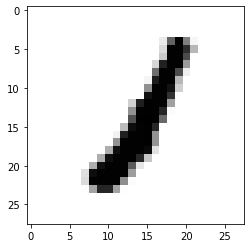

In [7]:
# Print some images
diter = iter(train_dataloader)
images, labels = diter.next()

print(images.shape)
print(labels.shape)

%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

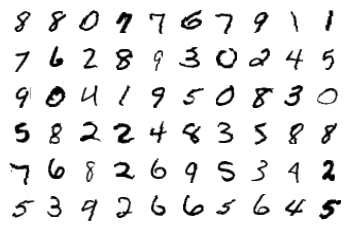

In [8]:
figure = plt.figure()
num_images = 60
for index in range(1, num_images+1):
  plt.subplot(6, 10, index)
  plt.axis('off')
  plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Model

In [9]:
dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=18, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(18),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 

        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        #x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [10]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
              ReLU-2           [-1, 12, 26, 26]               0
       BatchNorm2d-3           [-1, 12, 26, 26]              24
           Dropout-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 18, 24, 24]           1,944
              ReLU-6           [-1, 18, 24, 24]               0
       BatchNorm2d-7           [-1, 18, 24, 24]              36
           Dropout-8           [-1, 18, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             144
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 12, 10, 10]             864
             ReLU-12           [-1, 12, 10, 10]               0
      BatchNorm2d-13           [-1, 12, 10, 10]              24
          Dropout-14           [-1

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [11]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [12]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.08, momentum=0.9)
scheduler = StepLR(optimizer, step_size=8, gamma=0.01)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_dataloader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_dataloader)

EPOCH: 0


Loss=0.006810970604419708 Batch_id=937 Accuracy=94.05: 100%|██████████| 938/938 [00:14<00:00, 64.20it/s]



Test set: Average loss: 0.0563, Accuracy: 9820/10000 (98.20%)

EPOCH: 1


Loss=0.014805768616497517 Batch_id=937 Accuracy=97.72: 100%|██████████| 938/938 [00:14<00:00, 64.81it/s]



Test set: Average loss: 0.0376, Accuracy: 9882/10000 (98.82%)

EPOCH: 2


Loss=0.027132673189044 Batch_id=937 Accuracy=98.05: 100%|██████████| 938/938 [00:14<00:00, 64.90it/s]



Test set: Average loss: 0.0402, Accuracy: 9868/10000 (98.68%)

EPOCH: 3


Loss=0.09064525365829468 Batch_id=937 Accuracy=98.31: 100%|██████████| 938/938 [00:14<00:00, 64.17it/s]



Test set: Average loss: 0.0379, Accuracy: 9889/10000 (98.89%)

EPOCH: 4


Loss=0.06904435902833939 Batch_id=937 Accuracy=98.48: 100%|██████████| 938/938 [00:14<00:00, 64.68it/s]



Test set: Average loss: 0.0302, Accuracy: 9899/10000 (98.99%)

EPOCH: 5


Loss=0.024222832173109055 Batch_id=937 Accuracy=98.57: 100%|██████████| 938/938 [00:14<00:00, 64.46it/s]



Test set: Average loss: 0.0295, Accuracy: 9901/10000 (99.01%)

EPOCH: 6


Loss=0.002936724806204438 Batch_id=937 Accuracy=98.60: 100%|██████████| 938/938 [00:14<00:00, 65.03it/s]



Test set: Average loss: 0.0232, Accuracy: 9917/10000 (99.17%)

EPOCH: 7


Loss=0.036799706518650055 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [00:14<00:00, 65.20it/s]



Test set: Average loss: 0.0261, Accuracy: 9903/10000 (99.03%)

EPOCH: 8


Loss=0.25563138723373413 Batch_id=937 Accuracy=98.78: 100%|██████████| 938/938 [00:14<00:00, 64.49it/s]



Test set: Average loss: 0.0245, Accuracy: 9911/10000 (99.11%)

EPOCH: 9


Loss=0.00856387335807085 Batch_id=937 Accuracy=98.88: 100%|██████████| 938/938 [00:14<00:00, 65.16it/s]



Test set: Average loss: 0.0217, Accuracy: 9923/10000 (99.23%)

EPOCH: 10


Loss=0.05884627252817154 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [00:14<00:00, 64.20it/s]



Test set: Average loss: 0.0207, Accuracy: 9928/10000 (99.28%)

EPOCH: 11


Loss=0.0025583666283637285 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [00:14<00:00, 64.86it/s]



Test set: Average loss: 0.0205, Accuracy: 9930/10000 (99.30%)

EPOCH: 12


Loss=0.038112301379442215 Batch_id=937 Accuracy=98.99: 100%|██████████| 938/938 [00:14<00:00, 64.23it/s]



Test set: Average loss: 0.0212, Accuracy: 9929/10000 (99.29%)

EPOCH: 13


Loss=0.03332771360874176 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [00:14<00:00, 64.72it/s]



Test set: Average loss: 0.0198, Accuracy: 9934/10000 (99.34%)

EPOCH: 14


Loss=0.22595801949501038 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:14<00:00, 65.00it/s]



Test set: Average loss: 0.0196, Accuracy: 9934/10000 (99.34%)



Text(0.5, 1.0, 'Test Accuracy')

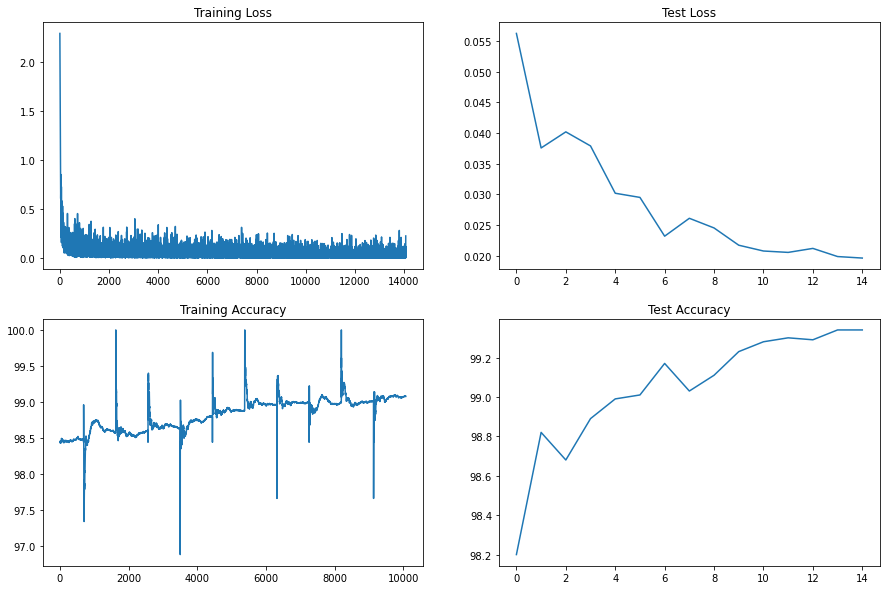

In [13]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")